# Spam or Ham (project 1)

## 1- Introduction with the Bernoulli model


We say that a random variables $X \in \{0, 1\}$ follows a Bernoulli distribution of parameter $\theta$ if $\mathbb{P}(X = 1) = \theta$ and $\mathbb{P}(X = 0) = 1 − \theta$.


1.  Show that we can write the probability distribution of $X$ in a compact form as : 
$$
\mathbb{P}(X = x) = \theta^{x} (1 − \theta)^{1−x}
$$

2. Suppose now that we have a set of n independent variables $x_1,...,x_n$. If we note $n_1 = \sum_{i=1}^n \mathbb{1}_{\{x_i=1\}}$ and $n_0 = n − n_1$, show that :
$$
\mathbb{P}(x_1,\ldots,x_n \mid \theta)=\theta^{n_1} (1−\theta)^{n_0}
$$

3. Show that the maximum likelihood estimator is $\hat{\theta}_{ML} = \frac{n_1}{n}$

4. A conjugate prior for the Bernoulli distribution is the Beta distribution. 
$$
Beta(\theta \mid a, b) \propto \theta^{a−1} (1 − \theta)^{b−1}
$$
Show that with a $Beta(a,b)$ prior the posterior distribution 
$\mathbb{P}(\theta \mid x_1,\ldots, x_n)$
is proportional to $\theta^{n_1+a-1} \cdot (1 − \theta)^{n_0+b-1}$ 

5. (Those two questions are optional, you can also simply use the result in the following)

  a. Show that the maximum a posteriori _mode_ estimate is in the form $\bar{\theta}_{MAP} = \frac{n_1+a-1}{n+a+b-2}$

  b. Show that the maximum a posteriori 
_mean_ estimate is in the form $\hat{\theta}_{MAP} = \mathbb{E}(\theta \mid x_1,\ldots, x_n) = 
\int_{\theta =0}^1 \mathbb{P}(\theta \mid x_1\ldots x_n) d\theta  = \frac{n_1+a}{n+a+b}$


## _write your answers to the questions here (you can also provide a scanned pdf of your answers with the notebook)_

## Spam classifier

The goal of this small project is to use a Naive bayes classifier to build a spam filter. To build our filter, we will use a dataset of 5,572 SMS messages put together by Tiago A. Almeida and José María Gómez Hidalgo. 
The dataset and the article describing the dataset are in the whiteboard directory together with this notebook. Of note, the SMS messages have already been processed for ease of use: all punctuation marks have been removed and the text has been transformed into lowercase. It is also common practice to remove any stop words such as `a`, `as`, `the` and to perform stemming (reduce words to their base form, such as stripping  the final `s*` in plural words, or the `*ing` from verbs (e.g., running becomes run)). For the sake of simplicity, we did not do that in this exercise.

We will use a bag of word model:
 - We construct a corpus of the possible words $\mathcal{D} = \{w_1, \ldots , w_d\}$.
 - Each document is described by a vector of binary values $(x^{(1)}, \ldots , x^{(d)})$ where $x^{(i)} = 1$ if $w_i$ occurs in the document and $0$ otherwise.

The classification task is to predict for an SMS message if it is a _spam_ or a _ham_ (e.g. non-spam).

Our data is thus $\mathbf{x} = (x^{(1)},\ldots, x^{(d)})$, $x^{(i)} \in \{0,1\}$ and $y \in \{s,h\}$
We hypothesise that the values $x^{(i)}$ are drawn according to a Bernoulli distribution whose parameter depends on the class:
$$
\mathbb{P}(x^{(i)} \mid y = s) = \theta_{i,s}^{x^{(i)}} \cdot (1-\theta_{i,s})^{1-x^{(i)}}
$$
and 
$$
\mathbb{P}(x^{(i)} \mid y = h) = \theta_{i,h}^{x^{(i)}} \cdot (1-\theta_{i,h})^{1-x^{(i)}}
$$
As we will use a naive Bayes classifier, the occurences of the different words are independent from each other.
\begin{align}
\mathbb{P}(\mathbf{x} \mid y = s) & = \prod_{i=1}^{d} \mathbb{P} (x^{(i)} \mid y = s)\\
  & =  \prod_{i=1}^{d} \theta_{i,s}^{x^{(i)}} \cdot (1-\theta_{i,s})^{1-x^{(i)}}
\end{align}


## Importing library and loading dataset

In [5]:
%matplotlib inline
import numpy as np
from collections import Counter

##Load the dataset (if in the same directory as the notebook)
sms_data = np.loadtxt("./SMSSpamCollection_cleaned.csv", delimiter="\t", skiprows=1, dtype=str)

## create test data set for checkpointing
checkpoint_data = np.array([['spam', 'dear researcher submit manuscript money'], 
          ['ham','dear friend meet beer'],
          ['ham', 'dear friend meet you']], dtype=str)

In [6]:
##Check the dataset
sms_data

array([['ham',
        'go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   '],
       ['ham', 'ok lar    joking wif u oni   '],
       ['spam',
        'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005  text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s'],
       ...,
       ['ham',
        'pity    was in mood for that  so   any other suggestions '],
       ['ham',
        'the guy did some bitching but i acted like i d be interested in buying something else next week and he gave it to us for free'],
       ['ham', 'rofl  its true to its name']], dtype='<U910')

In [24]:
##Check the size of the dataset
num_messages = sms_data.shape[0]
print(num_messages)

##third message is a...
print("Third message is a:", sms_data[2][0])
##dividing the third message into words
print(sms_data[2][1].split())

5572
Third message is a: spam
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', '08452810075over18', 's']


## 2 - Construction of the Corpus

Construct the corpus $\mathcal{D}$ of all words in the dataset. The corpus will be represented as a hash table where each key is a unique word in the dataset and each value is the row index for that word. 
 - How many unique words are there? 
 - What are the 10 most common words (_e.g._ occuring in the most documents)?
 - Transform the set of messages in the form of a binary matrix of word occurrences.
 
 You can evaluate whether your implementation works using the checkpoint_data array. For this dataset the corpus could look as follows :

`{'dear': 0, 'researcher': 1, 'submit': 2, 'manuscript': 3, 'money': 4, 'friend': 5, 'meet': 6, 'beer': 7, 'you': 8}`
(of course you could have other index values for the words). 

The recoding of the checkpoint data will give you the following numpy array:

```
[[1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 1.]]
```

In [59]:
def construct_corpus(data):
    """
    np.array[str, str] -> dict[str:int]
    
    from a 2D array of str, return a hash table
    """
    
    word_counts = {}
    index = 0

    for row in data:
        message = row[1].split()
    
        for word in message:
            if word not in word_counts:
                word_counts[word] = index
                index += 1
    
    return word_counts

word_counts = construct_corpus(checkpoint_data)

reverse_word_counts = {value: key for key, value in word_counts.items()}

print(reverse_word_counts)

print(word_counts)

{0: 'dear', 1: 'researcher', 2: 'submit', 3: 'manuscript', 4: 'money', 5: 'friend', 6: 'meet', 7: 'beer', 8: 'you'}
{'dear': 0, 'researcher': 1, 'submit': 2, 'manuscript': 3, 'money': 4, 'friend': 5, 'meet': 6, 'beer': 7, 'you': 8}


In [62]:
def recode_messages(data, corpus):
    """
    np.array[str, str] * dict[str:int] -> np.array[int, int]
    
    returns the binary matrix encoding 
    """
    
    numberOfMessages = data.shape[0]
    
    recoded_messages = arr = np.zeros((numberOfMessages, len(corpus)))
    
    for i in range(numberOfMessages):
        message = data[i][1].split()
        
        for word in message:
            recoded_messages[i][corpus[word]] = 1
        
    return recoded_messages
    
recoded_messages = recode_messages(checkpoint_data, word_counts)
    
print(recoded_messages)
    
D = construct_corpus(sms_data)

reverse_D = {value: key for key, value in D.items()}

sms_matrix = recode_messages(sms_data, D)

[[1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 1.]]


## 3 - Construct a training and a testing set and estimation of parameters


To do the evaluation of the model afterward we will split the dataset randomly in two: 
- one dataset for training (80% of the messages) 
- one dataset for testing (20% of the messages).

If you are familiar with it, you can use the `sklearn.model_selection` functions to construct the train and test datasets.


In [53]:
from sklearn.model_selection import train_test_split

X = sms_matrix

Y = np.array([label[0] for label in sms_data])

X_checkpoint = recoded_messages

Y_checkpoint = np.array([label[0] for label in checkpoint_data])

train_percentage = 0.8

assert X.shape[0] == Y.shape[0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = train_percentage)

## 4 - Estimation of the model parameters

We will now estimate our model on the training set. This means estimating two types of parameters: the class prior, and the conditional word occurence probabilities.

1.  Estimate the class prior $\mathbb{P}(c) = \mathbb{P}(y = c), (c = s, h)$
2.  Using the results from section 1, compute the Maximum a posteriori estimator for the $d \times 2$ matrix of parameters.
$$
\Theta = \left(
\begin{array}{cc}
\theta_{1,h}   & \theta_{1,s} \\
\theta_{2,h} & \theta_{2,s} \\
\vdots & \vdots \\
\theta_{d,h} & \theta_{d,s} \\
\end{array}
\right).
$$ You can use as conjugate prior a Beta(1, 1) distribution for instance (then $\theta_{i,c} = \frac{n_{i,c}+1}{N+2}$ where $n_{i,c}$ is the number of documents from the class $c$ where the word $w_i$ is present and $N$ is the total number of documents).

When applied to the checkpoint data, your $\Theta$ matrix should look like this:

```
# h    s
[[0.75 0.5 ]  #'dear'
 [0.25 0.5 ]  #'researcher'
 [0.25 0.5 ]  #'submit'
 [0.25 0.5 ]  #'manuscript'
 [0.25 0.5 ]  #'money'
 [0.75 0.5 ]  #'friend'
 [0.75 0.5 ]  #'meet'
 [0.5  0.5 ]  #'beer'
 [0.5  0.5 ]] #'you'
```

3. Represent the fitted class conditional densities $(\theta_{i,h})_{i \in \mathcal{D}}$ and $(\theta_{i,s})_{i \in \mathcal{D}}$ like on the corresponding slide (16?) of the course.


0.6666666666666666 0.3333333333333333
[[0.75       0.66666667]
 [0.25       0.66666667]
 [0.25       0.66666667]
 [0.25       0.66666667]
 [0.25       0.66666667]
 [0.75       0.33333333]
 [0.75       0.33333333]
 [0.5        0.33333333]
 [0.5        0.33333333]]


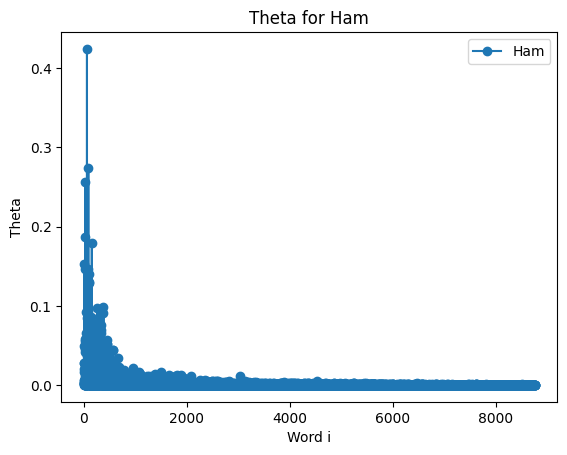

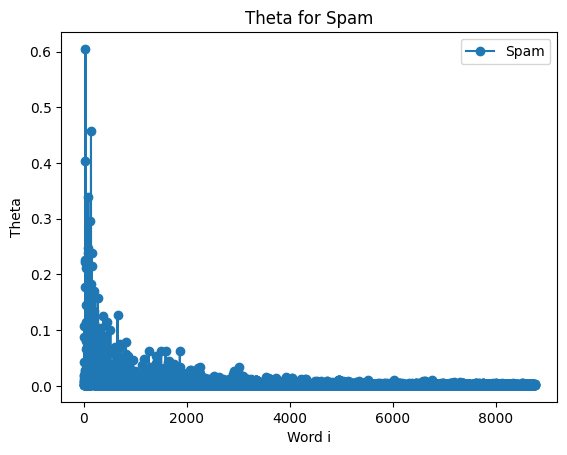

In [66]:
import matplotlib.pyplot as plt

# 1.

## Your code here for class priors
def estimate_class_priors(labels):
    
    n_samples = labels.shape[0]

    n_ham = np.sum(labels == "ham")
    n_spam = np.sum(labels == "spam")

    p_ham = n_ham / n_samples
    p_spam = n_spam / n_samples

    return p_ham, p_spam

# 2.

def estimate_proportions(data_matrix, labels):
    """
    estimate the matrix theta
    """
    
    assert labels.shape[0] == data_matrix.shape[0]
    
    n_words = data_matrix.shape[1]
    n_ham = np.sum(labels == "ham")
    n_spam = np.sum(labels == "spam")

    theta = np.zeros((n_words, 2))

    for i in range(n_words):
        n_word_ham = np.sum((data_matrix[:, i] == 1) & (labels == "ham"))
        n_word_spam = np.sum((data_matrix[:, i] == 1) & (labels == "spam"))
                
        theta[i, 0] = (n_word_ham + 1) / (n_ham + 2)    # n_ham should be N (n_words)
        theta[i, 1] = (n_word_spam + 1) / (n_spam + 2)  # n_spam should be N (n_words)

    return theta

p_ham_checkpoint, p_spam_checkpoint = estimate_class_priors(Y_checkpoint)

print(p_ham_checkpoint, p_spam_checkpoint)

theta_checkpoint = estimate_proportions(X_checkpoint, Y_checkpoint)

print(theta_checkpoint)

p_ham, p_spam = estimate_class_priors(Y_train)

theta = estimate_proportions(X_train, Y_train)

# 3.

# separate the theta values for ham and spam
theta_ham = theta[:, 0]
theta_spam = theta[:, 1]

# create a range of feature indices for the x-axis
i = np.arange(len(theta_ham))

# create the ham plot
plt.plot(i, theta_ham, '-o', label='Ham')
plt.xlabel('Word i')
plt.ylabel('Theta')
plt.title('Theta for Ham')
plt.legend()

# create the spam plot
plt.figure()
plt.plot(i, theta_spam, '-o', label='Spam')
plt.xlabel('Word i')
plt.ylabel('Theta')
plt.title('Theta for Spam')
plt.legend()

plt.show()

##
Dico = {'dear': 0, 'researcher':1, 'money': 2, 'friend': 3 }
#sentence 1 dear friend money 
#sentence 2 dear researcher friend
#sentence 3 friend money money
datam = np.array([[1, 0, 1, 1],[1, 1, 0, 1 ],[0, 0, 1, 1]], dtype = int)


## 4 - Message classification


3. Classify the messages in the test set using the Maximum a posteriori rule, and evaluate the performance of the model by computing the True Positive Rate (also called Sensitivity) and the False Positive Rate (the same as 1-Specificity).

4. The performance of the model above was obtained by using a classification threshold of $0.5$ on the posterior probability. In other words, if $\mathbb{P}(y = s \mid \mathbb{x}) \ge 0.5$ then the message is classified as spam. Draw a ROC curve for your classifier. Note that you have to consider multiple values of the threshold to draw the ROC curve. 

5. Why did we use the Maximum a posteriori estimator rather than the maximum likelihood one?




In [75]:
def predict(X_test, theta, p_ham, p_spam):
    
    n_messages, n_words = X_test.shape
    
    y_pred = np.zeros(n_messages)
    
    for i in range(n_messages):
        
        log_ratio = np.log(p_spam / p_ham)
        
        for j in range(n_words):
            
            if X_test[i, j] == 1:
                log_ratio += np.log(theta[j, 1] / theta[j, 0])
                
            else:
                log_ratio += np.log((1 - theta[j, 1]) / (1 - theta[j, 0]))
                
        y_pred[i] = 1 if log_ratio > 0 else 0
                
    return y_pred

predictions = predict(X_test, theta, p_ham, p_spam)

(1115, 8753)


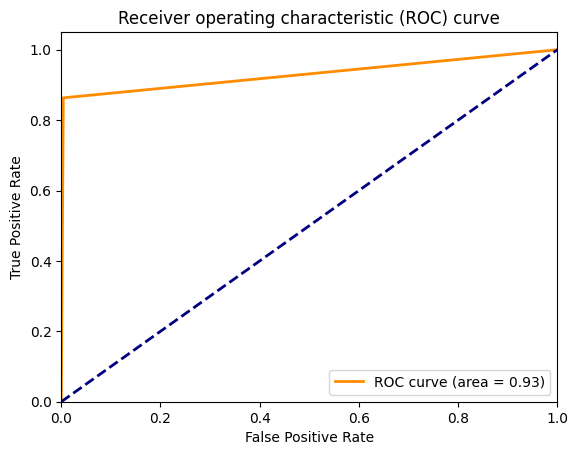

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(y_true, predictions)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

## 5 - Extension of the model (optional) 

One extension of the model is to consider a matrix of word counts instead of simply their presence/absence. 
The model will change in various ways in this case: 
   - We will count the total number of occurence in the spam or the ham set for each word.
   - the words are now considered to occur independently along the sentence. (independent Multinoulli). Thus, for a document with k words $\mathbf{v}=(v_1,\ldots, v_k)$
    \begin{align}
    \mathbb{P}(\mathbf{v} \mid y = s) 
  & =  \prod_{t=1}^{k} p_{v_t}
    \end{align}
       where $p_v$ is the probability to observe a word $v$
       
Note that with this new model we compute a product over the positions in the sentence while the bernoulli model did a product over all the words in the corpus.

1. Implement the estimation of parameters for this model and the computation of the posterior class probabilities. 
2. Compare its accuracy and ROC curve with the previous model on a test set.

